<a href="https://colab.research.google.com/github/Justinezgh/SBI-Diff-Simulator/blob/u%2FJustinezgh%2Fourmethod/notebooks/Our_SBI_method_on_LV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet numpyro dm-haiku==0.0.5 optax

In [ ]:
!pip install git+https://github.com/Justinezgh/SBI-Diff-Simulator.git#@u/EiffL/Infra

In [ ]:
!pip install chainconsumer

In [ ]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [5]:
%pylab inline
import arviz as az
az.style.use("arviz-darkgrid")

Populating the interactive namespace from numpy and matplotlib


In [6]:
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import numpyro
from numpyro.handlers import seed, trace, condition
from functools import partial

In [7]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [8]:
from sbids.tasks import lotka_volterra, get_samples_and_scores
#from sbids.models import AffineSigmoidCoupling, ConditionalRealNVP

In [9]:
from chainconsumer import ChainConsumer

In [11]:
# truth 
key = jax.random.PRNGKey(0)
lokta_volterra_10 = partial(lotka_volterra, ts=jnp.linspace(0,18.9,5))
lvcond = condition(lokta_volterra_10, {'z':jnp.array([30.0, 1.0])})
(log_probs0, samples0), scores = get_samples_and_scores(lvcond, key, batch_size=1)
observation0 = samples0['y']
observation = np.reshape(observation0, (-1,10), order='F')
truth0 = samples0['theta']

In [12]:
# create data train 
key = jax.random.PRNGKey(10)
(log_probs, samples), score = get_samples_and_scores(lvcond, key, batch_size=5e5)
batch = samples['y']
batch = np.reshape(batch, (-1,10), order='F')
mu = samples['theta']


if (batch > 500).any() == True:
  idx = jnp.where(batch > 500)[0]
  batch = jnp.delete(batch, idx, axis=0)
  mu = jnp.delete(mu, idx, axis=0)
  score = jnp.delete(score, idx, axis=0)

if jnp.isnan(batch).any() == True:
  idx = jnp.where(jnp.isnan(batch))[0]
  batch = jnp.delete(batch, idx, axis=0)
  mu = jnp.delete(mu, idx, axis=0)
  score = jnp.delete(score, idx, axis=0)

# normalize data 
scale_theta = (jnp.std(mu, axis =0)/0.02)
shift_theta = jnp.mean(mu/scale_theta, axis = 0)-0.4
normalized_p = (mu/scale_theta) - shift_theta

scale_reg = (jnp.std(batch, axis =0)/0.01)
shift_reg = jnp.mean(batch/scale_reg, axis = 0)-0.4
normalized_reg = (batch/scale_reg) - shift_reg

transformation_params = tfb.Chain([tfb.Scale(scale_theta),tfb.Shift(shift_theta)])
transformation_x = tfb.Chain([tfb.Scale(scale_reg),tfb.Shift(shift_reg)])


# create data stream
batch_size = 1000
ntrain = len(batch)
num_batches = ntrain // batch_size 

def data_stream():
  """
  Creates a data stream with a predifined batch size.
  """
  rng = np.random.RandomState(0)
  while True:
    perm = rng.permutation(ntrain)
    for i in range(num_batches):
      batch_idx = perm[i * batch_size: (i + 1)*batch_size]
      yield normalized_reg[batch_idx], normalized_p[batch_idx], score[batch_idx]

batches = data_stream()

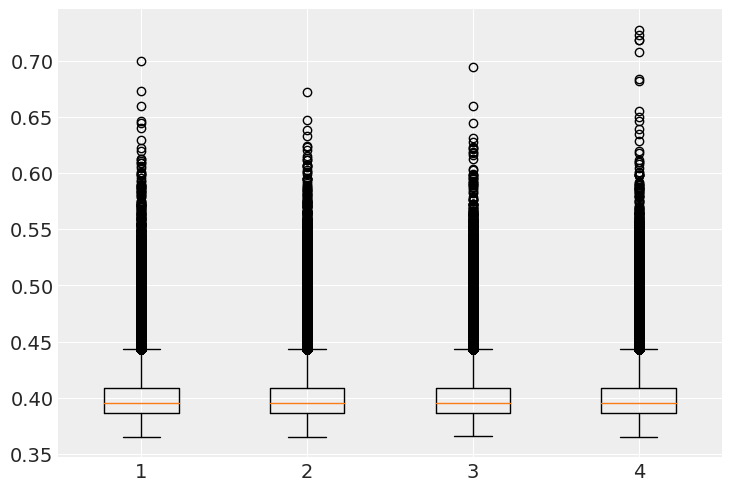

In [22]:
plt.boxplot([normalized_p[...,0],normalized_p[...,1],normalized_p[...,2],normalized_p[...,3]]);

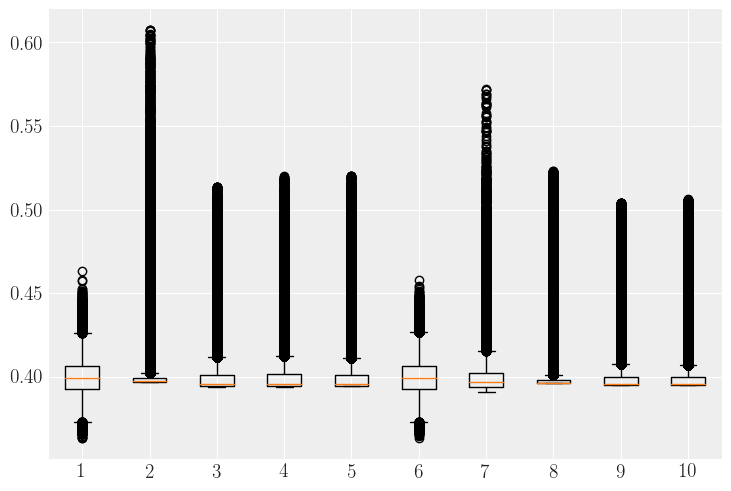

In [96]:
plt.boxplot([normalized_reg[...,0],
             normalized_reg[...,1],
             normalized_reg[...,2],
             normalized_reg[...,3],
             normalized_reg[...,4],
             normalized_reg[...,5],
             normalized_reg[...,6],
             normalized_reg[...,7],
             normalized_reg[...,8],
             normalized_reg[...,9]]);
            

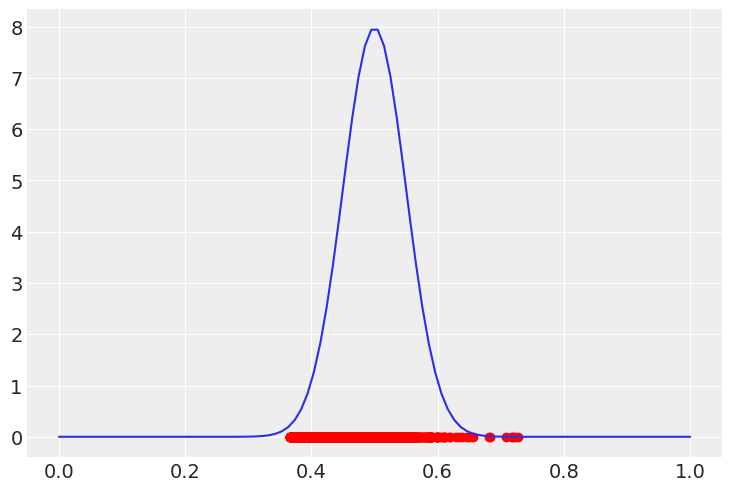

In [29]:
dist = tfd.Normal(0.5,0.05)
axe = jnp.linspace(0,1,100)
plt.plot(axe,dist.prob(axe))
plt.scatter(normalized_p[...,3], jnp.zeros(len(normalized_p[...,3])),c='r')

In [13]:
import jax.numpy as jnp
import jax
import haiku as hk

import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

from sbids.bijectors.bijectors import MixtureAffineSigmoidBijector

class AffineSigmoidCoupling(hk.Module):
  """This is the coupling layer used in the Flow."""
  def __init__(self, y, *args, layers=[128, 128], n_components=32, activation=jax.nn.silu, **kwargs):
    """ 
    Args: 
    y, conditioning variable
    layers, list of hidden layers
    n_components, number of mixture components
    activation, activation function for hidden layers
    """
    self.y = y
    self.layers = layers
    self.n_components = n_components
    self.activation = activation
    super(AffineSigmoidCoupling, self).__init__(*args, **kwargs)

  def __call__(self, x, output_units, **condition_kwargs):
   
    net = jnp.concatenate([x, self.y], axis=-1)
    for i, layer_size in enumerate(self.layers):
      net = self.activation(hk.Linear(layer_size, name='layer%d' % i)(net))
    
    log_a_bound=4
    min_density_lower_bound=1e-4
    n_components=self.n_components
    
    log_a = jax.nn.tanh(hk.Linear(output_units*n_components, name='l3')(net)) * log_a_bound
    b   = hk.Linear(output_units*n_components, name='l4')(net)
    c   = min_density_lower_bound + jax.nn.sigmoid(hk.Linear(output_units*n_components, name='l5')(net)) * (1 - min_density_lower_bound)
    p   = hk.Linear(output_units*n_components, name='l6')(net)

    log_a = log_a.reshape(-1,output_units,n_components)
    b = b.reshape(-1,output_units,n_components)
    c = c.reshape(-1,output_units,n_components)
    p = p.reshape(-1,output_units,n_components)
    p = jax.nn.softmax(p)

    return MixtureAffineSigmoidBijector(jnp.exp(log_a),b,c,p)

class ConditionalRealNVP(hk.Module):
  """A normalizing flow based on RealNVP using specified bijector functions."""

  def __init__(self, d, *args, n_layers=3, bijector_fn=AffineSigmoidCoupling, **kwargs):
    """
    Args:
    d, dimensionality of the input
    n_layers, number of layers
    coupling_layer, list of coupling layers
    """
    self.d = d
    self.n_layer = n_layers
    self.bijector_fn = bijector_fn
    super(ConditionalRealNVP, self).__init__(*args, **kwargs)
    
  def __call__(self, y):
    chain = tfb.Chain([
          tfb.Permute(jnp.arange(self.d)[::-1])(tfb.RealNVP(self.d//2, bijector_fn=self.bijector_fn(y, name = 'b%d'%i))) for i in range(self.n_layer)
      ])
    
    nvp = tfd.TransformedDistribution(
          tfd.MultivariateNormalDiag(0.5*jnp.ones(self.d), scale_identity_multiplier=0.05),
          bijector=chain)
    
    return nvp

In [14]:
from functools import partial

In [41]:
bijector = partial(AffineSigmoidCoupling, 
                   layers = [256,256,256],
                   n_components = 32, 
                   activation = jax.nn.silu)

NF = partial(ConditionalRealNVP,n_layers = 4, bijector_fn = bijector)

nvp_nd = hk.without_apply_rng(hk.transform(lambda p,x : NF(4)(x).log_prob(p).squeeze()))
nvp_sample_nd = hk.transform(lambda x : NF(4)(x).sample(10000, seed=hk.next_rng_key()))

In [ ]:
rng_seq = hk.PRNGSequence(5)
params_nd = nvp_nd.init(next(rng_seq),  0.4*jnp.ones([1,4]), 0.4*jnp.ones([1,10]))

In [43]:
scheduler = optax.exponential_decay(init_value=0.001, transition_steps=2000, decay_rate=0.9, end_value=0.00001)
optimizer = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(scheduler), optax.scale(-1))
opt_state = optimizer.init(params_nd)

In [44]:
from tqdm import tqdm

In [45]:
def loss_fn(params, weight, mu, batch, score):
  log_prob, out = jax.vmap(jax.value_and_grad(lambda theta, x: nvp_nd.apply(params, theta.reshape([1,4]), x.reshape([1,10])).squeeze()))(mu, batch)
  return -jnp.mean(log_prob) + weight * jnp.mean(jnp.sum((out - score)**2, axis=1)) 


@jax.jit
def update(params, opt_state, weight, mu, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, weight, mu, batch, score)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [46]:
def train(params, opt_state, weight):

  return params, opt_state, loss

In [97]:
  # train 
  #losses = []
  num_epochs = 20
  weight = 0 
  
  for epochs in tqdm(range(num_epochs)):
    for _ in range(num_batches):
      b,m,s = next(batches)    
      l, params_nd, opt_state = update(params_nd, opt_state,weight, m,  b, s)
      losses.append(l)
      

      if jnp.isnan(l)==True:
        print('NAN')
        break

      params_nd_t = params_nd

    if jnp.isnan(l)==True:
      print('NAN')
      break    


100%|██████████| 20/20 [06:08<00:00, 18.42s/it]


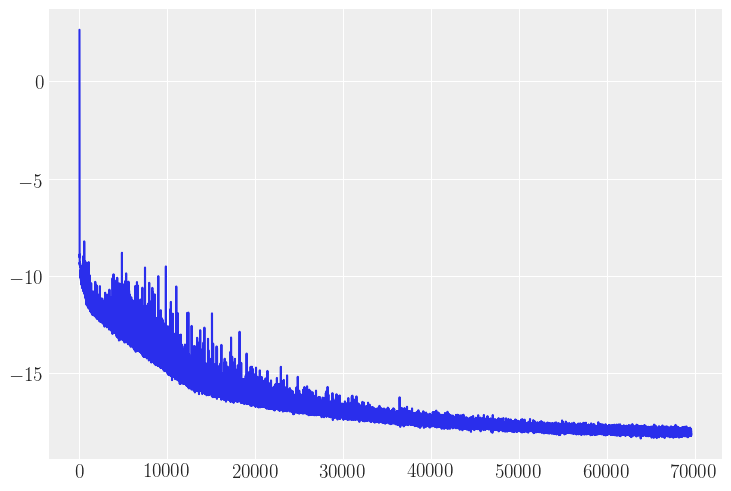

In [98]:
plt.plot(losses)

In [99]:
key = jax.random.PRNGKey(0)
lokta_volterra_10 = partial(lotka_volterra, ts=jnp.linspace(0,18.9,5))
lvcond = condition(lokta_volterra_10, {'z':jnp.array([30.0, 1.0])})
(log_probs0, samples0), scores = get_samples_and_scores(lvcond, key, batch_size=1)
observation0 = samples0['y']
observation = np.reshape(observation0, (-1,10), order='F')
truth0 = samples0['theta']

In [ ]:
sample_nd = nvp_sample_nd.apply(params_nd, rng = next(rng_seq), x = transformation_x.inverse(observation)*jnp.ones([int(10000),10]))

In [101]:
test_samples_fixed=jnp.load('/content/posterior_z_fixedkey0-4.npy')

/usr/local/lib/python3.7/dist-packages/chainconsumer/plotter.py:943: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.05 * spacing, hspace=0.05 * spacing)


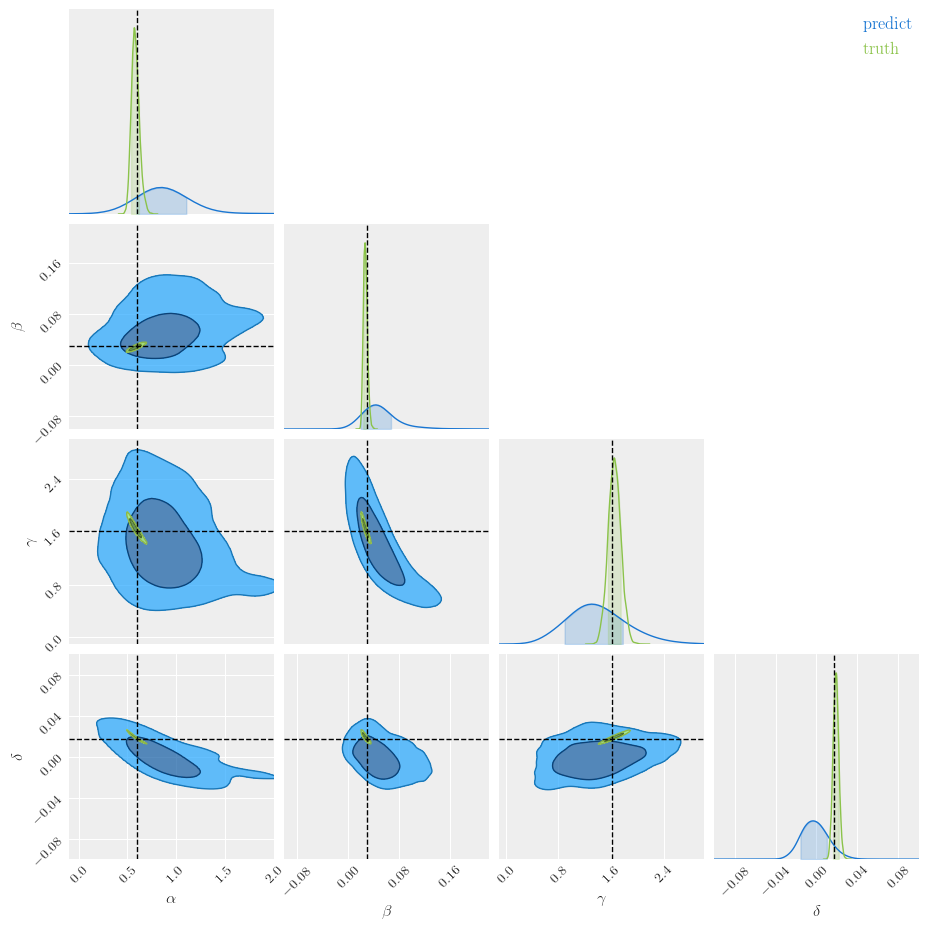

In [102]:
parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()

c.add_chain(transformation_params.forward(sample_nd), parameters=parameters, name="predict")
c.add_chain(test_samples_fixed, parameters=parameters, name="truth")
fig = c.plotter.plot(figsize=[10,10], 
                     truth=[0.603503  , 0.03026864, 1.6093055 , 0.01722082],
                     extents={r'$\alpha$': (-0.1,2),
                              r'$\beta$':(-0.1,0.22),
                              r'$\gamma$':(-0.1,3),
                              r'$\delta$':(-0.1,0.1),})
